# Discretizing AR(1) Processes - Examples

Here we compare the three methods we know that discretize AR(1) processes:

- [Tauchen (1986)](https://www.sciencedirect.com/science/article/pii/0165176586901680)
- [Tauchen and Hussey (1991)](https://doi.org/10.2307/2938261)
- Rouwenhorst, revamped by [Kopecky and Suen (2010)](https://doi.org/10.1016/j.red.2010.02.002)

The explanation of what these do are in Marco's slides and in the [notebook of the related TA session](../ta_sessions/3_stochastic_methods.ipynb).
Here we just visually compare the results they give.

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt

# Do not run this outside Jupyter Notebooks
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
plt.rcParams['figure.figsize'] = [10, 5]

First, we define the functions that operate the discretization.

In [2]:
def tauchen(N, m, mu, rho, sigma):
    r"""
    Applies Tauchen's method [1]_ to discretize an AR(1) process of the form

    .. math:: x_t = (1-\rho) \mu + \rho x_{t-1} + \varepsilon_t, \qquad
              \varepsilon_t \overset{iid}{\sim} \mathcal{N}(0, \sigma^2)

    Parameters
    ----------
    N : int
         Number of points on discrete support grid.
    m : float
         Multiplier for setting how far away the endpoints on grid are.
    mu : float
         Unconditional mean of the AR(1) process.
    rho : float
          Persistence parameter in the AR(1) process. Make it within the unit
          circle, please!
    sigma : float
            Standard deviation of the innovation process.

    Returns
    -------
    S : ndarray
         The discrete support grid for the Markov Chain.
    pi : ndarray
         The one-step-ahead transition matrix that matches properties of the
         AR(1) model.

    References
    ----------
    .. [1] Tauchen, G., (1986). "Finite State Markov-Chain Approximations to
           Univariate and Vector Autoregressions." Economics Letters,
           20(2):177–181.
    """
    s_max = m * sigma
    S, step = np.linspace(-s_max, s_max, num=N, retstep=True)
    x = S - rho * S.reshape((-1, 1)) + step / 2
    pi = norm.cdf(x / sigma)
    pi[:, -1] = 1.
    pi[:, 1:] = np.diff(pi)
    S += mu  # centering everything around unconditional mean
    return S, pi


def tauchussey(N, mu, rho, sigma):
    r"""
    Applies Tauchen-Hussey's method [1]_ to discretize an AR(1) process of the
    form

    .. math:: x_t = (1-\rho) \mu + \rho x_{t-1} + \varepsilon_t, \qquad
              \varepsilon_t \overset{iid}{\sim} \mathcal{N}(0, \sigma^2)

    Parameters
    ----------
    N : int
         Number of points on discrete support grid.
    mu : float
         Unconditional mean of the AR(1) process.
    rho : float
          Persistence parameter in the AR(1) process. Make it within the unit
          circle, please!
    sigma : float
            Standard deviation of the innovation process.

    Returns
    -------
    S : ndarray
         The discrete support grid for the Markov Chain.
    pi : ndarray
         The one-step-ahead transition matrix that matches properties of the
         AR(1) model.

    References
    ----------
    .. [1] G. Tauchen and R. Hussey (1991). "Quadrature-Based Methods for
           Obtaining Approximate Solutions to Nonlinear Asset Pricing Models."
           Econometrica, 59(2):371.
    """
    S, step = np.polynomial.hermite.hermgauss(N)
    S *= np.sqrt(2) * sigma
    pdf = (norm.pdf(S, rho * S.reshape((-1, 1)), sigma) /
           norm.pdf(S, 0, sigma))
    pi = step / np.sqrt(np.pi) * pdf
    pi /= pi.sum(axis=1, keepdims=True)
    S += mu  # centering everything around unconditional mean
    return S, pi


def rouwenhorst(N, mu, rho, sigma):
    r"""
    Applies Rouwenhorst's method [1]_ to discretize an AR(1) process of the
    form

    .. math:: x_t = (1-\rho) \mu + \rho x_{t-1} + \varepsilon_t, \qquad
              \varepsilon_t \overset{iid}{\sim} \mathcal{N}(0, \sigma^2)

    Parameters
    ----------
    N : int
         Number of points on discrete support grid.
    mu : float
         Unconditional mean of the AR(1) process.
    rho : float
          Persistence parameter in the AR(1) process. Make it within the unit
          circle, please!
    sigma : float
            Standard deviation of the innovation process.

    Returns
    -------
    S : ndarray
         The discrete support grid for the Markov Chain.
    pi : ndarray
         The one-step-ahead transition matrix that matches properties of the
         AR(1) model.

    References
    ----------
    .. [1] K. A. Kopecky and R. M. H. Suen (2010). "Finite State Markov-Chain
           Approximations to Highly Persistent Processes." Review of Economic
           Dynamics, 13(3):701–714.
    """

    def compute_P(p, N):
        if N == 2:
            P = np.array([[p, 1-p],
                          [1-p, p]])
        else:
            Q = compute_P(p, N-1)
            A = np.zeros((N, N))
            B = np.zeros((N, N))
            A[:N-1, :N-1] += Q
            A[1:N, 1:N] += Q
            B[:N-1, 1:N] += Q
            B[1:N, :N-1] += Q
            P = p * A + (1 - p) * B
            P[1:-1, :] /= 2
        return P

    p = (1 + rho) / 2
    P = compute_P(p, N)
    f = np.sqrt(N-1) * (sigma / np.sqrt(1-rho**2))
    s = np.linspace(-f, f, N) + mu
    return s, P

Note that I used the docstrings to document the use and the purpose of these functions.

Next, we define two classes that will be useful: `AR1` and `MarkovChain`.

In [3]:
class AR1:

    def __init__(self, alpha, rho, sigma):
        self.alpha = alpha
        self.rho = rho
        self.sigma = sigma
        self.average = alpha / (1 - rho)
        self.stdev = np.sqrt(sigma ** 2 / (1 - rho ** 2))

    def autocov(self, h):
        if h < 0:
            raise ValueError('Specify positive horizon (you know, symmetry...)')
        return self.stdev ** 2 * self.rho ** h

    def simulate(self, T, x0):
        x = np.zeros((T + 2,))
        x[0] = x0
        for t in range(1, T + 2):
            x[t] = (self.alpha + self.rho * x[t - 1] +
                    np.random.normal(scale=self.sigma))

        return x[2:]


class MarkovChain:

    def __init__(self, pi):
        if not np.allclose(np.sum(pi, axis=1), np.ones(pi.shape[0])):
            raise ValueError('Each row of the input matrix must sum to one.')
        self.Pi = pi

    def n_steps_transition(self, n):
        return la.matrix_power(self.Pi, n)

    @property
    def stationary_distribution(self):
        l, v = la.eig(self.Pi)
        vector = v[:, np.where(np.isclose(l, 1.))]
        return (vector / np.sum(vector)).reshape((-1,))

    def simulate(self, T, s0):
        """
        It simulates a Markov Chain for T periods given that the initial
        state is 's'. The parameter 's' must be an integer between 0 and
        Pi.shape[0]-1
        """
        if T < 1:
            raise ValueError('The sample length T must be at least 1.')
        if not isinstance(s0, int):
            raise TypeError('Initial condition must be an index (integer).')
        if s0 < 0 or s0 > self.Pi.shape[0] - 1:
            raise ValueError('Initial condition must be a row index of Pi.')

        def draw_state(pdf):
            cdf = np.cumsum(pdf)
            u = np.random.uniform()
            return np.sum(u - cdf > 0)

        sample = np.zeros((T,), dtype=int)
        sample[0] = s0
        for t in range(1, T):
            sample[t] = draw_state(self.Pi[sample[t - 1], :])

        return sample

Each class has methods.

- `AR1` has the following ones:
    - `__init__`: allows us to instatiate the AR(1) process with the constant `alpha`, the coefficient of persistence `rho` and the standard deviation of the innovations `sigma`.
    - `autocov`: computes the autocovariance $cov(y_t, y_{t+h})$ for a given horizon `h`.
    - `simulate`: creates a time series of `T` synthetic observations with initial condition `x0`.

- `MarkovChain` has the following:
    - `__init__`:
    - `n_steps_transition`:
    - `stationary_distribution`:
    - `simulate`:
    
We then move on to create the artificial AR(1) processes and we discretize them with the methods above.    

In [4]:
T = 250
mu0 = mu1 = 0.
sigma0 = sigma1 = 1.
rho0, rho1 = 0.25, 0.95

# Applying the various discretization methods
N = 11
m = 3  # only used for Tauchen's method
s_mc0t, p_mc0t = tauchen(N, m, mu0, rho0, sigma0)
s_mc1t, p_mc1t = tauchen(N, m, mu1, rho1, sigma1)
s_mc0th, p_mc0th = tauchussey(N, mu0, rho0, sigma0)
s_mc1th, p_mc1th = tauchussey(N, mu1, rho1, sigma1)
s_mc0r, p_mc0r = rouwenhorst(N, mu0, rho0, sigma0)
s_mc1r, p_mc1r = rouwenhorst(N, mu1, rho1, sigma1)

We simulate each process, both the continuous AR(1)'s and the Markov Chains.

In [5]:
ar0 = AR1((1 - rho0) * mu0, mu0, sigma0).simulate(T, 0)
ar1 = AR1((1 - rho1) * mu1, mu1, sigma1).simulate(T, 0)
std0 = sigma0 / np.sqrt(1 - rho0 ** 2)
std1 = sigma1 / np.sqrt(1 - rho1 ** 2)

i_mc0t = MarkovChain(p_mc0t).simulate(T, N // 2)    # assuming N odd
i_mc1t = MarkovChain(p_mc1t).simulate(T, N // 2)    # assuming N odd
i_mc0th = MarkovChain(p_mc0th).simulate(T, N // 2)  # assuming N odd
i_mc1th = MarkovChain(p_mc1th).simulate(T, N // 2)  # assuming N odd
i_mc0r = MarkovChain(p_mc0r).simulate(T, N // 2)    # assuming N odd
i_mc1r = MarkovChain(p_mc1r).simulate(T, N // 2)    # assuming N odd

mc0t = s_mc0t[i_mc0t]
mc1t = s_mc0t[i_mc1t]
mc0th = s_mc0th[i_mc0th]
mc1th = s_mc0th[i_mc1th]
mc0r = s_mc0r[i_mc0r]
mc1r = s_mc0r[i_mc1r]

We finally plot the results to have a comparison.
Here we standardize some properties we use later on.

In [6]:
sets_main = {'linewidth': 1, 'color': 'red'}
sets_avg = {'linewidth': 0.5, 'color': 'black', 'linestyle': 'solid'}
sets_bands = {'linewidth': 0.5, 'color': 'black', 'linestyle': 'dashed'}
label_path = 'Sample path'
label_avg0 = r'$\mu_0$'
label_avg1 = r'$\mu_1$'
label_band0_lo = r'$\mu_0 - \sqrt{\sigma_0^2 / (1-\rho_0^2)}$'
label_band0_hi = r'$\mu_0 + \sqrt{\sigma_0^2 / (1-\rho_0^2)}$'
label_band1_lo = r'$\mu_1 - \sqrt{\sigma_1^2 / (1-\rho_1^2)}$'
label_band1_hi = r'$\mu_1 + \sqrt{\sigma_1^2 / (1-\rho_1^2)}$'
title_left  = r'AR(1) w/$\rho = {:.3g}$'
title_right = r'AR(1) passed to Tauchen w/$\rho = {:.3g}$'

First, we start with looking at Tauchen's method.

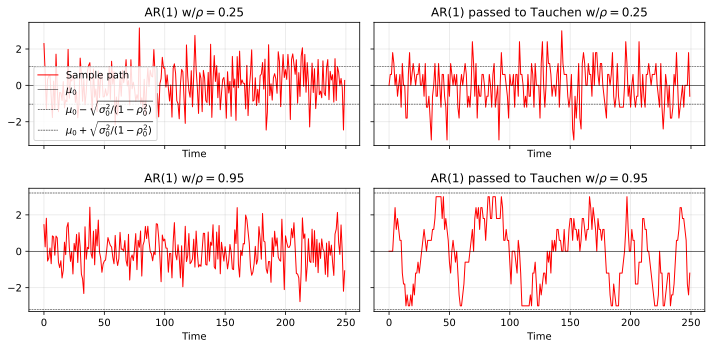

In [7]:
figt, axt = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

axt[0, 0].plot(ar0,  **sets_main, label=label_path)
axt[0, 1].plot(mc0t, **sets_main, label=label_path)
axt[1, 0].plot(ar1,  **sets_main, label=label_path)
axt[1, 1].plot(mc1t, **sets_main, label=label_path)

for j in range(2):
    axt[0, j].axhline(mu0, **sets_avg, label=label_avg0)
    axt[0, j].axhline(mu0 - std0, **sets_bands, label=label_band0_lo)
    axt[0, j].axhline(mu0 + std0, **sets_bands, label=label_band0_hi)
    axt[1, j].axhline(mu1, **sets_avg, label=label_avg1)
    axt[1, j].axhline(mu1 - std1, **sets_bands, label=label_band1_lo)
    axt[1, j].axhline(mu1 + std1, **sets_bands, label=label_band1_hi)

for i in range(2):
    for j in range(2):
        axt[i, j].grid(alpha=0.3)
        axt[i, j].set_xlabel('Time')

axt[0, 0].legend(loc='lower left', framealpha=0.85)

axt[0, 0].set_title(title_left.format(rho0))
axt[1, 0].set_title(title_left.format(rho1))
axt[0, 1].set_title(title_right.format(rho0))
axt[1, 1].set_title(title_right.format(rho1))

plt.tight_layout()
plt.show()

Now we turn to Tauchen-Hussey's method.

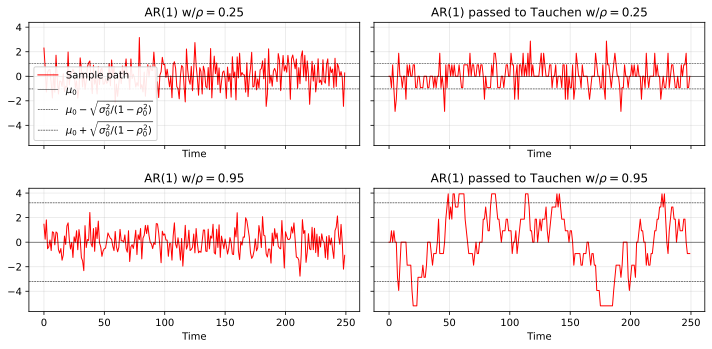

In [8]:
figth, axth = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

axth[0, 0].plot(ar0,   **sets_main, label=label_path)
axth[0, 1].plot(mc0th, **sets_main, label=label_path)
axth[1, 0].plot(ar1,   **sets_main, label=label_path)
axth[1, 1].plot(mc1th, **sets_main, label=label_path)

for j in range(2):
    axth[0, j].axhline(mu0, **sets_avg, label=label_avg0)
    axth[0, j].axhline(mu0 - std0, **sets_bands, label=label_band0_lo)
    axth[0, j].axhline(mu0 + std0, **sets_bands, label=label_band0_hi)

    axth[1, j].axhline(mu1, **sets_avg, label=label_avg1)
    axth[1, j].axhline(mu1 - std1, **sets_bands, label=label_band1_lo)
    axth[1, j].axhline(mu1 + std1, **sets_bands, label=label_band1_hi)

for i in range(2):
    for j in range(2):
        axth[i, j].grid(alpha=0.3)
        axth[i, j].set_xlabel('Time')

axth[0, 0].legend(loc='lower left', framealpha=0.9)

axth[0, 0].set_title(title_left.format(rho0))
axth[1, 0].set_title(title_left.format(rho1))
axth[0, 1].set_title(title_right.format(rho0))
axth[1, 1].set_title(title_right.format(rho1))

plt.tight_layout()
plt.show()

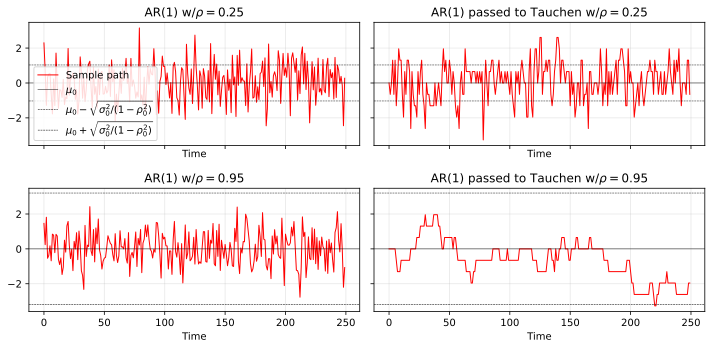

In [9]:
figr, axr = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

axr[0, 0].plot(ar0,  **sets_main, label=label_path)
axr[0, 1].plot(mc0r, **sets_main, label=label_path)
axr[1, 0].plot(ar1,  **sets_main, label=label_path)
axr[1, 1].plot(mc1r, **sets_main, label=label_path)

for j in range(2):
    axr[0, j].axhline(mu0, **sets_avg, label=r'$\mu_0$')
    axr[0, j].axhline(mu0 - std0, **sets_bands, label=label_band0_lo)
    axr[0, j].axhline(mu0 + std0, **sets_bands, label=label_band0_hi)
    axr[1, j].axhline(mu1, **sets_avg, label=r'$\mu_1$')
    axr[1, j].axhline(mu1 - std1, **sets_bands, label=label_band1_lo)
    axr[1, j].axhline(mu1 + std1, **sets_bands, label=label_band1_hi)

for i in range(2):
    for j in range(2):
        axr[i, j].grid(alpha=0.3)
        axr[i, j].set_xlabel('Time')

axr[0, 0].legend(loc='lower left', framealpha=0.85)

axr[0, 0].set_title(title_left.format(rho0))
axr[1, 0].set_title(title_left.format(rho1))
axr[0, 1].set_title(title_right.format(rho0))
axr[1, 1].set_title(title_right.format(rho1))

plt.tight_layout()
plt.show()